<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Approach" data-toc-modified-id="Approach-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Approach</a></span></li><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Check-Missing-values" data-toc-modified-id="Check-Missing-values-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check Missing values</a></span></li><li><span><a href="#imbalanced-classes" data-toc-modified-id="imbalanced-classes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>imbalanced classes</a></span></li><li><span><a href="#Split-dataset-to-train-and-test-set" data-toc-modified-id="Split-dataset-to-train-and-test-set-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Split dataset to train and test set</a></span></li><li><span><a href="#Create-Preprocessing/-Training-Pipeline" data-toc-modified-id="Create-Preprocessing/-Training-Pipeline-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Create Preprocessing/ Training Pipeline</a></span><ul class="toc-item"><li><span><a href="#Functions-for-plotting-metrics" data-toc-modified-id="Functions-for-plotting-metrics-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Functions for plotting metrics</a></span></li><li><span><a href="#Binary-Classification-Evaluator" data-toc-modified-id="Binary-Classification-Evaluator-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Binary Classification Evaluator</a></span></li><li><span><a href="#Train-and-log-models" data-toc-modified-id="Train-and-log-models-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Train and log models</a></span></li></ul></li><li><span><a href="#Cross-Validation/-Hyperparameter-Tuning" data-toc-modified-id="Cross-Validation/-Hyperparameter-Tuning-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Cross Validation/ Hyperparameter Tuning</a></span><ul class="toc-item"><li><span><a href="#Tuning-the-Dtree-model" data-toc-modified-id="Tuning-the-Dtree-model-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Tuning the Dtree model</a></span></li><li><span><a href="#Extract-feature-importances" data-toc-modified-id="Extract-feature-importances-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Extract feature importances</a></span></li><li><span><a href="#log-the-best-model-to-mlflow" data-toc-modified-id="log-the-best-model-to-mlflow-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>log the best model to mlflow</a></span></li></ul></li><li><span><a href="#Persisting-the-best-model-pipeline" data-toc-modified-id="Persisting-the-best-model-pipeline-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Persisting the best model pipeline</a></span></li></ul></div>

### Approach
**The purpose of this notebook is to show the steps mentioned below:**
- how to create model training pipeline
- how to capture/log results and models using **mlflow**
- how to persist the trained models and use them for prediction

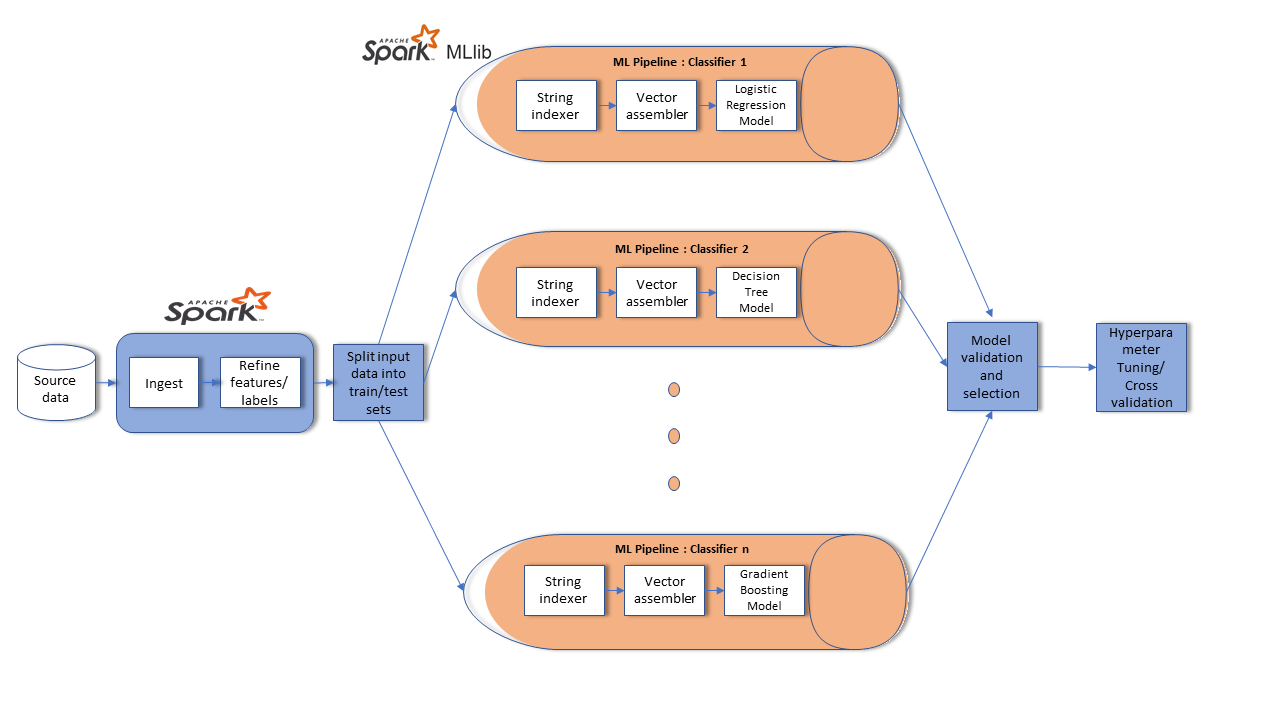


### Import Libraries

In [14]:
#find the spark instance
import findspark
findspark.init()

In [15]:
# Including MLflow
import mlflow
import mlflow.spark
import os
import math
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from pyspark.sql import SparkSession

In [16]:
#get the spark session
spark = SparkSession.builder.getOrCreate()
spark

In [17]:
# File location and type
file_location = "data/PL_XSELL.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df.limit(10).toPandas().head()

,CUST_ID,TARGET,AGE,GENDER,BALANCE,OCCUPATION,AGE_BKT,SCR,HOLDING_PERIOD,ACC_TYPE,...,NO_OF_IW_CHQ_BNC_TXNS,NO_OF_OW_CHQ_BNC_TXNS,AVG_AMT_PER_ATM_TXN,AVG_AMT_PER_CSH_WDL_TXN,AVG_AMT_PER_CHQ_TXN,AVG_AMT_PER_NET_TXN,AVG_AMT_PER_MOB_TXN,FLG_HAS_NOMINEE,FLG_HAS_OLD_LOAN,random
0,C7927,0,27,M,3383.75,SELF-EMP,26-30,776,30,SA,...,0,0,13100.0,0.0,0.0,486778.50,0.0,1,1,0.000011
1,C6877,0,47,M,287489.04,SAL,46-50,324,28,SA,...,0,0,6600.0,0.0,0.0,799813.00,0.0,1,0,0.000111
2,C19922,0,40,M,18216.88,SELF-EMP,36-40,603,2,SA,...,0,1,11200.0,561120.0,24660.0,997570.00,0.0,1,1,0.000120
3,C8183,0,53,M,71720.48,SAL,>50,196,13,CA,...,0,0,13050.0,168397.5,15195.0,247168.67,71388.0,1,0,0.000137
4,C12123,0,36,M,1671622.89,PROF,36-40,167,24,SA,...,0,0,0.0,808480.0,0.0,0.00,0.0,1,0,0.000174


In [18]:
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- GENDER: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- OCCUPATION: string (nullable = true)
 |-- AGE_BKT: string (nullable = true)
 |-- SCR: integer (nullable = true)
 |-- HOLDING_PERIOD: integer (nullable = true)
 |-- ACC_TYPE: string (nullable = true)
 |-- ACC_OP_DATE: string (nullable = true)
 |-- LEN_OF_RLTN_IN_MNTH: integer (nullable = true)
 |-- NO_OF_L_CR_TXNS: integer (nullable = true)
 |-- NO_OF_L_DR_TXNS: integer (nullable = true)
 |-- TOT_NO_OF_L_TXNS: integer (nullable = true)
 |-- NO_OF_BR_CSH_WDL_DR_TXNS: integer (nullable = true)
 |-- NO_OF_ATM_DR_TXNS: integer (nullable = true)
 |-- NO_OF_NET_DR_TXNS: integer (nullable = true)
 |-- NO_OF_MOB_DR_TXNS: integer (nullable = true)
 |-- NO_OF_CHQ_DR_TXNS: integer (nullable = true)
 |-- FLG_HAS_CC: integer (nullable = true)
 |-- AMT_ATM_DR: integer (nullable = true)
 |-- AMT_BR_CSH_W

In [19]:
#drop columns which are not required
cols_to_drop = ['CUST_ID','ACC_OP_DATE','random']
df = df.drop(*cols_to_drop)

In [20]:
# now get names of categorical and numerical features 
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')

num_cols = [item[0] for item in df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')

4  categorical features
32  numerical features


### Check Missing values

In [21]:
 #count nullvalues in each columns
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas()

,TARGET,AGE,GENDER,BALANCE,OCCUPATION,AGE_BKT,SCR,HOLDING_PERIOD,ACC_TYPE,LEN_OF_RLTN_IN_MNTH,...,AMT_MIN_BAL_NMC_CHGS,NO_OF_IW_CHQ_BNC_TXNS,NO_OF_OW_CHQ_BNC_TXNS,AVG_AMT_PER_ATM_TXN,AVG_AMT_PER_CSH_WDL_TXN,AVG_AMT_PER_CHQ_TXN,AVG_AMT_PER_NET_TXN,AVG_AMT_PER_MOB_TXN,FLG_HAS_NOMINEE,FLG_HAS_OLD_LOAN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###  imbalanced classes

In [59]:
target_count = df.groupBy('TARGET').count().toPandas()
target_count['fraction'] = target_count['count'].apply(lambda c : round(c/df.count(),2))
target_count

,TARGET,count,fraction
0,1,2512,0.13
1,0,17488,0.87


In [23]:
# adding the new column weights and fill it with ratios
from pyspark.sql.functions import when

ratio = 0.87
def weight_balance(labels):
    return when(labels == 0, ratio).otherwise(1*(1-ratio))

df = df.withColumn('weights', weight_balance(col('TARGET')))
df.limit(10).toPandas().head()

,TARGET,AGE,GENDER,BALANCE,OCCUPATION,AGE_BKT,SCR,HOLDING_PERIOD,ACC_TYPE,LEN_OF_RLTN_IN_MNTH,...,NO_OF_IW_CHQ_BNC_TXNS,NO_OF_OW_CHQ_BNC_TXNS,AVG_AMT_PER_ATM_TXN,AVG_AMT_PER_CSH_WDL_TXN,AVG_AMT_PER_CHQ_TXN,AVG_AMT_PER_NET_TXN,AVG_AMT_PER_MOB_TXN,FLG_HAS_NOMINEE,FLG_HAS_OLD_LOAN,weights
0,0,27,M,3383.75,SELF-EMP,26-30,776,30,SA,146,...,0,0,13100.0,0.0,0.0,486778.50,0.0,1,1,0.87
1,0,47,M,287489.04,SAL,46-50,324,28,SA,104,...,0,0,6600.0,0.0,0.0,799813.00,0.0,1,0,0.87
2,0,40,M,18216.88,SELF-EMP,36-40,603,2,SA,61,...,0,1,11200.0,561120.0,24660.0,997570.00,0.0,1,1,0.87
3,0,53,M,71720.48,SAL,>50,196,13,CA,107,...,0,0,13050.0,168397.5,15195.0,247168.67,71388.0,1,0,0.87
4,0,36,M,1671622.89,PROF,36-40,167,24,SA,185,...,0,0,0.0,808480.0,0.0,0.00,0.0,1,0,0.87


### Split dataset to train and test set

In [24]:
# Initially split our dataset between training and test datasets
(train, test) = df.randomSplit([0.8, 0.2], seed=12345)
# Print out dataset counts
print("Total rows: %s, Training rows: %s, Test rows: %s" % (df.count(), train.count(), test.count()))

Total rows: 20000, Training rows: 15964, Test rows: 4036


### Create Preprocessing/ Training Pipeline
**We will try out following models with default settings :**
- Logistic Regression
- Random Forest Classifier
- Gradient Boosted Tree Classifier


In [25]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier,GBTClassifier
SEED = 123

In [26]:
# Encodes a string column of labels to a column of label indices
indexer = [StringIndexer(inputCol=c, outputCol='idx_' + c) for c in cat_cols]

#one hot encoding for indexed category columns
#ohe = OneHotEncoderEstimator(inputCols = ['idx_' + c for c in cat_cols],outputCols=['ohe_' + c for c in cat_cols])

assemblerInputs = ["idx_" + c for c in cat_cols] + num_cols
# VectorAssembler is a transformer that combines a given list of columns into a single vector column
va = VectorAssembler(inputCols = assemblerInputs , outputCol = "features")

pre_stages = indexer + [va]

#### Functions for plotting metrics

In [27]:
#Get Confusion matrix and plot it
from sklearn.metrics import confusion_matrix,roc_curve
import itertools
#function to get confusion matrix
def get_cmatrix(model,test):
    test_pred = np.array(model.transform(test).select('prediction').collect())
    cm =  confusion_matrix(np.array(test.select('TARGET').collect()), test_pred)
    return cm

#function to plot roc_curve
def plot_roc(model,test,label):
    test_pred = np.array(model.transform(test).select('probability').collect()).reshape(4036,2)[:,1]
    fpr, tpr, thresholds =  roc_curve(np.array(test.select('TARGET').collect()), test_pred)
    fig = plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=label)
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    fig.savefig("plots/ROC-curve.png")



#plot confusion matrix
def plot_confusion_matrix(cm, title = 'Confusion matrix'):
    # Clear Plot
    plt.gcf().clear()

    # Configure figure
    fig = plt.figure(1)

    # Configure plot
    classes = ['No Response', 'Response']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize and establish threshold
    normalize=False
    fmt = 'd'
    thresh = cm.max() / 2.

    # Iterate through the confusion matrix cells
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    # Final plot configurations
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    plt.grid(False)
    # Display images
    image = fig
    # Save plot
    fig.savefig("plots/confusion-matrix.png")
    # Display Plot
    display(image)
    # Close Plot
    plt.close(fig)


#### Binary Classification Evaluator

In [28]:
# Binary Classification Evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Use BinaryClassificationEvaluator to evaluate our model
evaluatorPR = BinaryClassificationEvaluator(labelCol = "TARGET", rawPredictionCol = "prediction", metricName = "areaUnderPR")
evaluatorAUC = BinaryClassificationEvaluator(labelCol = "TARGET", rawPredictionCol = "prediction", metricName = "areaUnderROC")

#method to evaluate model
def evaluate_model(train,test,model):
    # Build the best model (training and test datasets)
    train_pred = model.transform(train)
    test_pred = model.transform(test)

    # Evaluate the model on training datasets
    pr_train = evaluatorPR.evaluate(train_pred)
    auc_train = evaluatorAUC.evaluate(train_pred)

    # Evaluate the model on test datasets
    pr_test = evaluatorPR.evaluate(test_pred)
    auc_test = evaluatorAUC.evaluate(test_pred)

    # Print out the PR and AUC values
    print("PR train:", pr_train)
    print("AUC train:", auc_train)
    print("PR test:", pr_test)
    print("AUC test:", auc_test)
    return pr_train,auc_train,pr_test,auc_test     

#### Train and log models

In [71]:
#Function to train and log models
def fit_model(model_name,pipeline,train,test):
    with mlflow.start_run(run_name=model_name):
        model = pipeline.fit(train)
        pr_train,auc_train,pr_test,auc_test = evaluate_model(train,test,model)
        cm = get_cmatrix(model,test)
        plot_confusion_matrix(cm)
        # Log parameter, metrics, and model to MLflow
        #mlflow.log_param("max_depth", model.stages[-1]._java_obj.getMaxDepth())
        #mlflow.log_param("max_bins", model.stages[-1]._java_obj.getMaxBins())
        mlflow.log_metric("PR_train", pr_train)
        mlflow.log_metric("PR_test", pr_test)
        mlflow.log_metric("AUC_train", auc_train)
        mlflow.log_metric("AUC_test", auc_test)
        mlflow.log_artifact("plots/confusion-matrix.png")
        mlflow.log_artifact("plots/ROC-curve.png")
        mlflow.spark.log_model(model.stages[-1], "model")
        mlflow.end_run()

Training and logging :  Logistic Regression
PR train: 0.19730654090104693
AUC train: 0.6481795690111869
PR test: 0.2100045369729752
AUC test: 0.6629240413888391


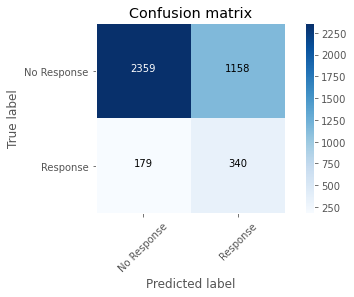

Trained and logged to mlflow...
Training and logging :  Decision Tree
PR train: 0.4281977074153314
AUC train: 0.5460588690579508
PR test: 0.3788253741375788
AUC test: 0.5405878849935053


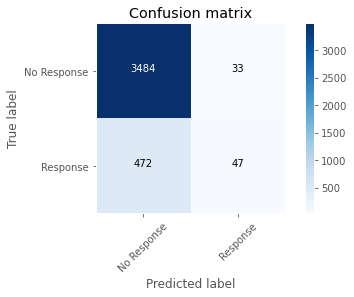

Trained and logged to mlflow...
Training and logging :  Gradient Boosting
PR train: 0.7269023814521622
AUC train: 0.7175488736380783
PR test: 0.6412833861275002
AUC test: 0.6592907118356587


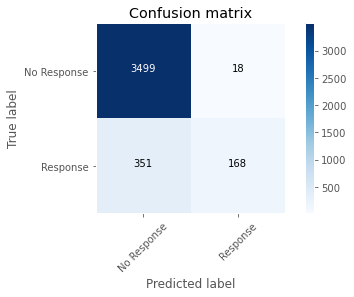

Trained and logged to mlflow...


In [72]:
# initialise the models
lr = LogisticRegression(labelCol = "TARGET", featuresCol = "features",thresholds=[0.87,0.13])
dt = DecisionTreeClassifier(labelCol = "TARGET", featuresCol = "features", seed = SEED )
gbt = GBTClassifier(labelCol = "TARGET", featuresCol = "features", seed = SEED,maxIter=100)

#Keep all the model objects in a dict
models = {'Logistic Regression' : lr,'Decision Tree' :dt,'Gradient Boosting' :gbt}

#train and log each models
for model_name,model in models.items():
    print('Training and logging : ', model_name)
    train_pipeline = Pipeline(stages = pre_stages + [model])
    fit_model(model_name,train_pipeline,train,test)
    print('Trained and logged to mlflow...')

### Cross Validation/ Hyperparameter Tuning

We'll create a cross validation pipeline to tune the DTree model from the previous step

#### Tuning the Dtree model

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Build the grid of different parameters
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [10, 20, 30]) \
    .addGrid(dt.minInstancesPerNode,[3,5,7])\
    .build()

# Build out the cross validation
allstages = pre_stages + [dt]
crossval = CrossValidator(estimator = Pipeline(stages = allstages),
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluatorAUC,
                          numFolds = 3,seed=SEED)  

# Train the model using the pipeline, parameter grid, and preceding BinaryClassificationEvaluator
cvModel = crossval.fit(train)

#### Extract feature importances

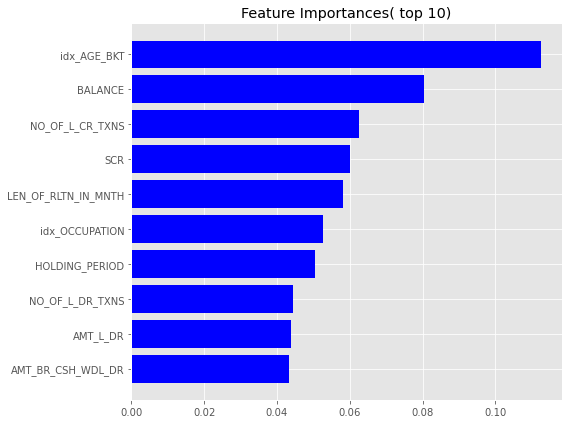

In [65]:
#Get the feature importances 
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    #return varlist
    return(varlist.sort_values('score', ascending = False))
train_pred = cvModel.bestModel.transform(train) 
feature_imp = ExtractFeatureImp(cvModel.bestModel.stages[5].featureImportances, train_pred, "features").head(10)\
                [['name','score']].sort_values(by = 'score')
fig = plt.figure(1,figsize=(8, 6))
plt.title('Feature Importances( top 10)')
#feature_imp.sort_values(by = 'score').plot('name','score',kind='barh',fig = fig)
plt.barh(feature_imp['name'],feature_imp['score'],color = 'b')
plt.tight_layout()
plt.show()
fig.savefig("plots/Feature-Importances.png")

#### log the best model to mlflow

PR train: 0.840582642961555
AUC train: 0.9061082840115768
PR test: 0.5780824108763832
AUC test: 0.8080594503000291


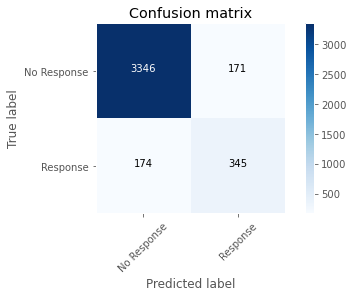

In [73]:
pr_train,auc_train,pr_test,auc_test = evaluate_model(train,test,cvModel.bestModel)
cm = get_cmatrix(cvModel.bestModel,test)
plot_confusion_matrix(cm)
with mlflow.start_run(run_name="Cross validated model"):
    mlflow.log_metric("PR_train", pr_train)
    mlflow.log_metric("PR_test", pr_test)
    mlflow.log_metric("AUC_train", auc_train)
    mlflow.log_metric("AUC_test", auc_test)
    mlflow.log_artifact("plots/confusion-matrix.png")
    mlflow.log_artifact("plots/ROC-curve.png")
    mlflow.log_artifact("plots/Feature-Importances.png")
    mlflow.spark.log_model(cvModel.bestModel.stages[-1], "model")

### Persisting the best model pipeline

In [89]:
#Save the best pipeline model for later use
modelPath = "/models/best_model.model"
cvModel.bestModel.write().overwrite().save(modelPath)